# New Analyses: YAASS and SCORE

### The dataset below includes demographic information and multiple clinical measures taken in 3 populations: healthy controls, those at clinical high risk for psychosis, and those diagnosed with schizophrenia. This is a follow-up to the YAASS.ipynb with FHR removed due to missing clinical measures.

In [1]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/YAASS/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/YAASS/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'

In [2]:
%cd {path2code}

import csv, misc, os, random, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.stats import zscore
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R suppressMessages(library('lmerTest'))
%R suppressMessages(library('lsmeans'))
%R lsm.options(disable.pbkrtest=TRUE)
%R suppressMessages(library('effsize')) # Can use this to estimate Cohen's d
%R suppressMessages(library('afex'))
%R suppressMessages(library('QuantPsyc')) #helpful for extracting betas from hierarchical regresssions
%R suppressMessages(library('vcd')) # useful for getting effect sizes from chi-square tests
%R suppressMessages(library('scales'))

/Users/elyssabarrick/Work/Expts/Code


array(['scales', 'vcd', 'grid', 'QuantPsyc', 'MASS', 'boot', 'afex',
       'reshape2', 'effsize', 'lsmeans', 'estimability', 'lmerTest',
       'lme4', 'Matrix', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], 
      dtype='<U12')

# Dataframe

In [6]:
#Load in SHL dataframe containing SCORE and YAASS data
beh = pd.read_csv(path2data + 'BehavioralData_05.22.17.csv')

In [43]:
beh.head(3)

,ID,Group,Gender,Age,Education,Ethnicity,IQ,DSMDisorder,DSMDisorderType,DSMcomorbidities,...,PANAS_PA,SIPS_Disorganized,SIPS_General,SIPS_Negative,SIPS_Positive,SocAdjScale_SocialLeisure,SocAdjScale_Work,GFS_Role,GFS_Social,Present_Clinical
0,27105,SZ,male,45,16.0,1.0,117.0,NaN,NaN,NaN,...,25.0,NaN,NaN,NaN,NaN,42.0,0.0,2.0,7.0,1.0
1,27108,SZ,male,32,16.0,1.0,106.0,NaN,NaN,NaN,...,38.0,NaN,NaN,NaN,NaN,61.0,58.0,7.0,7.0,1.0
2,27109,SZ,female,40,14.0,4.0,90.0,NaN,NaN,NaN,...,42.0,NaN,NaN,NaN,NaN,83.0,77.0,6.0,5.0,1.0


In [10]:
#Load in SCORE PANSS data
sx_SZ = pd.read_excel(path2data + 'PANSS_SCORE.xlsx', sheetname='EB')

In [44]:
sx_SZ.head(3)

,ID,PANSS_PA,PANSS_NA,PANSS_DA,PANSS_EA,PANSS_Dep_Anx,PANSS_Other
0,27105,4.4,1.571429,2.8,2.0,1.50,1.3
1,27108,3.2,2.142857,1.0,1.0,2.00,1.2
2,27109,1.6,1.428571,1.0,1.0,1.25,1.4


In [35]:
#Load in YAASS PANSS data
sx_chr = pd.read_excel(path2data + 'YAASS_Clinical_Data.xls', sheetname='EB')

In [45]:
sx_chr.head(3)

,ID,PANSS_PA,PANSS_NA,PANSS_DA,PANSS_EA,PANSS_Dep_Anx,PANSS_Other
0,26102,10.0,7.0,5.0,4.0,9.0,13.0
1,26104,12.0,7.0,5.0,4.0,5.0,10.0
2,26105,5.0,7.0,5.0,4.0,4.0,10.0


In [37]:
#Join the 2 PANSS dataframes
s = pd.concat([sx_SZ, sx_chr])

In [46]:
s.head(3)

,ID,PANSS_PA,PANSS_NA,PANSS_DA,PANSS_EA,PANSS_Dep_Anx,PANSS_Other
0,27105,4.4,1.571429,2.8,2.0,1.50,1.3
1,27108,3.2,2.142857,1.0,1.0,2.00,1.2
2,27109,1.6,1.428571,1.0,1.0,1.25,1.4


In [50]:
#Merge PANSS dataframe with SHL dataframe to have all scores together
raw = pd.merge(beh, s, on='ID')

In [51]:
raw.head(3)

,ID,Group,Gender,Age,Education,Ethnicity,IQ,DSMDisorder,DSMDisorderType,DSMcomorbidities,...,SocAdjScale_Work,GFS_Role,GFS_Social,Present_Clinical,PANSS_PA,PANSS_NA,PANSS_DA,PANSS_EA,PANSS_Dep_Anx,PANSS_Other
0,27105,SZ,male,45,16.0,1.0,117.0,NaN,NaN,NaN,...,0.0,2.0,7.0,1.0,4.4,1.571429,2.8,2.0,1.50,1.3
1,27108,SZ,male,32,16.0,1.0,106.0,NaN,NaN,NaN,...,58.0,7.0,7.0,1.0,3.2,2.142857,1.0,1.0,2.00,1.2
2,27109,SZ,female,40,14.0,4.0,90.0,NaN,NaN,NaN,...,77.0,6.0,5.0,1.0,1.6,1.428571,1.0,1.0,1.25,1.4


In [52]:
raw.columns

Index(['ID', 'Group', 'Gender', 'Age', 'Education', 'Ethnicity', 'IQ',
       'DSMDisorder', 'DSMDisorderType', 'DSMcomorbidities', 'IRI_EC_total',
       'IRI_FS_total', 'IRI_PD_total', 'IRI_PT_total', 'Chapman_MIS',
       'Chapman_PAS', 'Chapman_PhAS', 'Chapman_RTS', 'Chapman_SocAnh',
       'Medication', 'PANAS_NA', 'PANAS_PA', 'SIPS_Disorganized',
       'SIPS_General', 'SIPS_Negative', 'SIPS_Positive',
       'SocAdjScale_SocialLeisure', 'SocAdjScale_Work', 'GFS_Role',
       'GFS_Social', 'Present_Clinical', 'PANSS_PA', 'PANSS_NA', 'PANSS_DA',
       'PANSS_EA', 'PANSS_Dep_Anx', 'PANSS_Other'],
      dtype='object')

In [54]:
#Push dataframe to R to conduct statistical analyses
%Rpush raw
%R str(raw)

'data.frame':	73 obs. of  37 variables:
 $ ID                       : int  27105 27108 27109 27115 27116 27117 27128 27136 27142 27148 ...
 $ Group                    : Factor w/ 3 levels "CHR","HC","SZ": 3 3 3 3 3 3 3 3 3 3 ...
 $ Gender                   : Factor w/ 2 levels "female","male": 2 2 1 2 1 2 1 2 1 2 ...
 $ Age                      : int  45 32 40 42 53 53 34 24 58 38 ...
 $ Education                : num  16 16 14 13 14 14 14 16 12 18 ...
 $ Ethnicity                : num  1 1 4 1 1 1 2 2 1 1 ...
 $ IQ                       : num  117 106 90 108 102 121 85 125 111 99 ...
 $ DSMDisorder              : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ DSMDisorderType          : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ DSMcomorbidities         : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ IRI_EC_total             : num  29 42 34 32 29 NaN 37 35 41 31 ...
 $ IRI_FS_total             : num  30 29 21 25 35 NaN 25 25 42 15 ...
 $ IRI_PD_total             : n

# Demographics

In [55]:
print ('Total Group Count')
raw.groupby('Group')['ID'].nunique()

Total Group Count


Group
CHR    26
HC     21
SZ     26
Name: ID, dtype: int64

In [57]:
print ('Gender by Group')
raw.groupby('Group')['Gender'].value_counts()

Gender by Group


Group  Gender
CHR    male      17
       female     9
HC     female    11
       male      10
SZ     male      16
       female    10
dtype: int64

Age by Group
Group       
CHR    count    26.000000
       mean     21.846154
       std       4.342279
       min      15.000000
       25%      18.250000
       50%      22.000000
       75%      23.750000
       max      34.000000
HC     count    21.000000
       mean     22.857143
       std       4.053217
       min      18.000000
       25%      20.000000
       50%      22.000000
       75%      24.000000
       max      33.000000
SZ     count    26.000000
       mean     38.692308
       std      10.279180
       min      21.000000
       25%      31.250000
       50%      38.500000
       75%      44.750000
       max      58.000000
dtype: float64


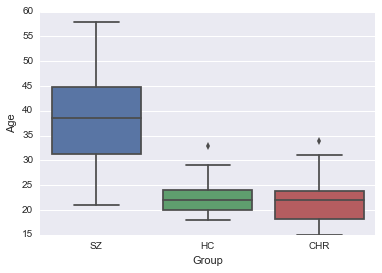

In [76]:
print ('Age by Group')
g=raw.groupby('Group')
print (g.Age.describe())

sns.boxplot(x='Group',y='Age',data=raw)

In [59]:
"""Dataframe dropping participants without an IQ value"""
raw_IQ = raw[np.isfinite(raw['IQ'])]

Group
CHR    106.791667
HC     115.476190
SZ     108.076923
Name: IQ, dtype: float64
ANOVA for IQ x Group


            Df Sum Sq Mean Sq F value Pr(>F)
Group        2    971   485.5   2.352  0.103
Residuals   68  14035   206.4               
2 observations deleted due to missingness


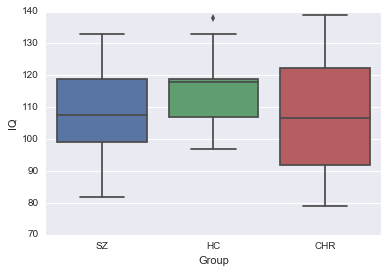

In [63]:
i = raw_IQ.groupby('Group')

print (i.IQ.mean())

sns.boxplot(x='Group',y='IQ',data=raw_IQ)

%Rpush raw_IQ
print ('ANOVA for IQ x Group')
%R iq.aov <- aov(IQ ~ Group, data=raw)
%R print (summary(iq.aov))

# Measures

## Global Functioning Scale (name?)

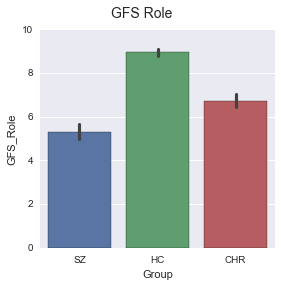

In [78]:
sns.factorplot(y='GFS_Role',x='Group',units='ID',ci=68,kind='bar',data=raw)
plt.subplots_adjust(top=0.9)
sns.plt.suptitle('GFS Role', fontsize=14)

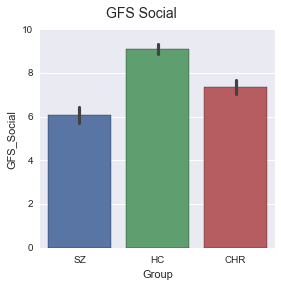

In [79]:
sns.factorplot(y='GFS_Social',x='Group',units='ID',ci=68,kind='bar',data=raw)

plt.subplots_adjust(top=0.9)
sns.plt.suptitle('GFS Social', fontsize=14)

## Social Adjustment Scale

In [73]:
x = raw.groupby('Group')

print('SAS Social Leisure Mean')
print(x.SocAdjScale_SocialLeisure.mean())

SAS Social Leisure Mean
Group
CHR    62.772727
HC     48.444444
SZ     63.680000
Name: SocAdjScale_SocialLeisure, dtype: float64


ANOVA on SAS Social Leisure x Group


            Df Sum Sq Mean Sq F value   Pr(>F)    
Group        2   2865    1432   10.45 0.000122 ***
Residuals   62   8496     137                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
8 observations deleted due to missingness


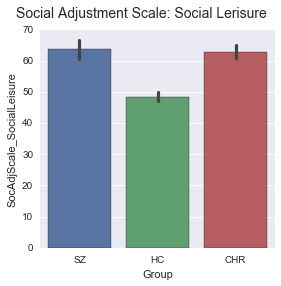

In [89]:
sns.factorplot(y='SocAdjScale_SocialLeisure',x='Group',units='ID',ci=68,kind='bar',data=raw)

plt.subplots_adjust(top=0.9)
sns.plt.suptitle('Social Adjustment Scale: Social Lerisure', fontsize=14)

print ('ANOVA on SAS Social Leisure x Group')


%R sas_sl.aov <- aov(SocAdjScale_SocialLeisure ~ Group,data=raw)
%R print (summary(sas_sl.aov))

            Df Sum Sq Mean Sq F value Pr(>F)  
Group        2   3939    1969   3.986 0.0235 *
Residuals   62  30630     494                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
8 observations deleted due to missingness


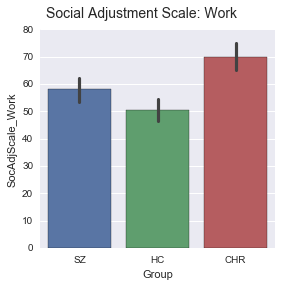

In [90]:
sns.factorplot(y='SocAdjScale_Work',x='Group',units='ID',ci=68,kind='bar',data=raw)
plt.subplots_adjust(top=0.9)
sns.plt.suptitle('Social Adjustment Scale: Work', fontsize=14)

%R sas_w.aov <- aov(SocAdjScale_Work ~ Group,data=raw)
%R print (summary(sas_w.aov))

## Interpersonal Reactivity Index

IRI_EC Mean
Group
CHR    28.500000
HC     33.947368
SZ     30.560000
Name: IRI_EC_total, dtype: float64
IRI_FS Mean
Group
CHR    28.291667
HC     25.526316
SZ     27.440000
Name: IRI_FS_total, dtype: float64
IRI_PD Mean
Group
CHR    22.333333
HC     16.578947
SZ     19.120000
Name: IRI_PD_total, dtype: float64
IRI_PT Mean
Group
CHR    27.791667
HC     34.000000
SZ     30.040000
Name: IRI_PT_total, dtype: float64
ANOVA on Empathic concern x Group


            Df Sum Sq Mean Sq F value Pr(>F)  
Group        2  316.6  158.29   4.726 0.0121 *
Residuals   65 2177.1   33.49                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
5 observations deleted due to missingness


ANOVA on Fantasy x Group


            Df Sum Sq Mean Sq F value Pr(>F)
Group        2   83.3   41.63   1.105  0.337
Residuals   65 2449.9   37.69               
5 observations deleted due to missingness


ANOVA on Personal Distress x Group


            Df Sum Sq Mean Sq F value  Pr(>F)   
Group        2  358.3  179.13   5.105 0.00872 **
Residuals   65 2280.6   35.09                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
5 observations deleted due to missingness


ANOVA on Perspective Taking x Group


            Df Sum Sq Mean Sq F value   Pr(>F)    
Group        2  412.6  206.31   8.192 0.000672 ***
Residuals   65 1636.9   25.18                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
5 observations deleted due to missingness


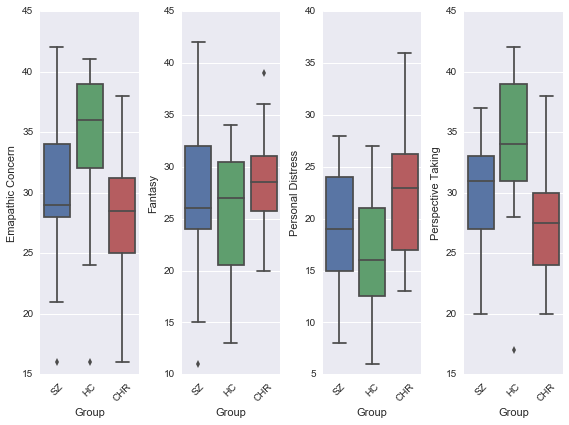

In [67]:

print('IRI_EC Mean')
print(g.IRI_EC_total.mean())
print('IRI_FS Mean')
print(g.IRI_FS_total.mean())
print('IRI_PD Mean')
print(g.IRI_PD_total.mean())
print('IRI_PT Mean')
print(g.IRI_PT_total.mean())

print ('ANOVA on Empathic concern x Group')
%R ec.aov <- aov(IRI_EC_total ~ Group, data=raw)
%R print (summary(ec.aov))
fig = plt.figure(figsize=(8, 6))
iri = fig.add_subplot(141)
sns.boxplot(y='IRI_EC_total', x='Group', data = raw)
plt.ylabel('Emapathic Concern')
plt.xticks(rotation=45)

print ('ANOVA on Fantasy x Group')
%R fs.aov <- aov(IRI_FS_total ~ Group, data=raw)
%R print (summary(fs.aov))
iri = fig.add_subplot(142)
sns.boxplot(y='IRI_FS_total', x='Group', data = raw)
plt.ylabel('Fantasy')
plt.xticks(rotation=45)

print ('ANOVA on Personal Distress x Group')
%R pd.aov <- aov(IRI_PD_total ~ Group, data=raw)
%R print (summary(pd.aov))
iri = fig.add_subplot(143)
sns.boxplot(y='IRI_PD_total', x='Group', data = raw)
plt.ylabel('Personal Distress')
plt.xticks(rotation=45)

print ('ANOVA on Perspective Taking x Group')
%R pt.aov <- aov(IRI_PT_total ~ Group, data=raw)
%R print (summary(pt.aov))
iri = fig.add_subplot(144)
sns.boxplot(y='IRI_PT_total', x='Group', data = raw)
plt.ylabel('Perspective Taking')
plt.xticks(rotation=45)
fig.tight_layout()

## Chapman

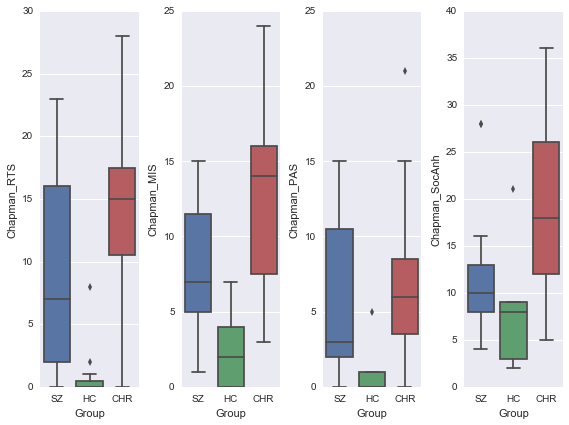

In [92]:
fig = plt.figure(figsize=(8, 6))
chap = fig.add_subplot(141)
sns.boxplot(y='Chapman_RTS', x='Group', data = raw)
chap = fig.add_subplot(142)
sns.boxplot(y='Chapman_MIS', x='Group', data = raw)
chap = fig.add_subplot(143)
sns.boxplot(y='Chapman_PAS', x='Group', data = raw)
chap = fig.add_subplot(144)
sns.boxplot(y='Chapman_SocAnh', x='Group', data = raw)
fig.tight_layout()

## Positive and Negative Syndrome Scale

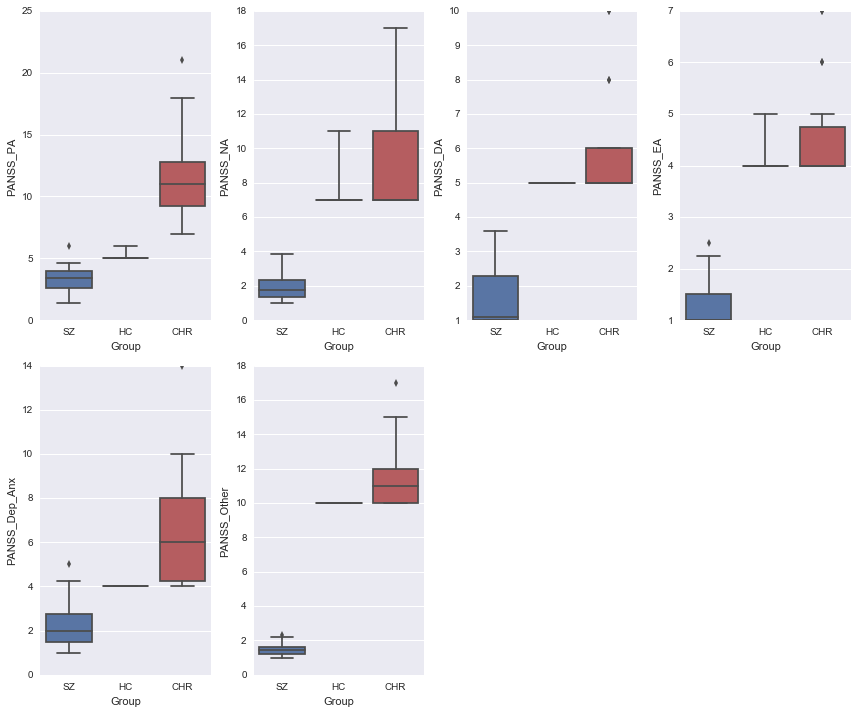

In [86]:
fig = plt.figure(figsize=(12, 10))
pns = fig.add_subplot(241)
sns.boxplot(y='PANSS_PA', x='Group', data = raw)
pns = fig.add_subplot(242)
sns.boxplot(y='PANSS_NA', x='Group', data = raw)
pns = fig.add_subplot(243)
sns.boxplot(y='PANSS_DA', x='Group', data = raw)
pns = fig.add_subplot(244)
sns.boxplot(y='PANSS_EA', x='Group', data = raw)
pns = fig.add_subplot(245)
sns.boxplot(y='PANSS_Dep_Anx', x='Group', data = raw)
pns = fig.add_subplot(246)
sns.boxplot(y='PANSS_Other', x='Group', data = raw)
fig.tight_layout()

In [65]:
raw.columns

Index(['ID', 'Group', 'Gender', 'Age', 'Education', 'Ethnicity', 'IQ',
       'DSMDisorder', 'DSMDisorderType', 'DSMcomorbidities', 'IRI_EC_total',
       'IRI_FS_total', 'IRI_PD_total', 'IRI_PT_total', 'Chapman_MIS',
       'Chapman_PAS', 'Chapman_PhAS', 'Chapman_RTS', 'Chapman_SocAnh',
       'Medication', 'PANAS_NA', 'PANAS_PA', 'SIPS_Disorganized',
       'SIPS_General', 'SIPS_Negative', 'SIPS_Positive',
       'SocAdjScale_SocialLeisure', 'SocAdjScale_Work', 'GFS_Role',
       'GFS_Social', 'Present_Clinical', 'PANSS_PA', 'PANSS_NA', 'PANSS_DA',
       'PANSS_EA', 'PANSS_Dep_Anx', 'PANSS_Other'],
      dtype='object')